GAN: https://vbarra.github.io/DLbook/gan.html
VAE: https://vbarra.github.io/DLbook/vae.html

# 1. Setup and Data Handling

## 1.1. Environment Setup
Libraries: Install necessary libraries: tensorflow, keras, numpy, matplotlib, urllib (you can also add tqdm for progress bars). Consider using tensorflow-gpu if you have a compatible GPU.

Reproducibility: Set random seeds for TensorFlow and NumPy to ensure reproducibility.

Notebook Setup: Start your Jupyter Notebook and import all the necessary libraries in the first cell.

Constants: Define constants like IMAGE_SIZE, BATCH_SIZE, CLASSES, DATA_DIR, etc. at the beginning of your notebook.

Using Python 3.9.21

In [ ]:
!pip install tensorflow numpy matplotlib urllib3 jupyter tqdm

In [103]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 3.9 MB/s eta 0:00:00a 0:00:01


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Constants ---
IMAGE_SIZE = 28       # Height and width of the images
CHANNELS = 1          # Number of channels in the images (grayscale)
BATCH_SIZE = 64       # Batch size for training
LATENT_DIM_GAN = 128  # Dimension of the random noise vector for the generator
EPOCHS = 50           # Number of training epochs (you might need more)
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']  # Chosen classes
DATA_DIR = "quickdraw_data"  # Directory to store the data
MAX_ITEMS_PER_CLASS = 5000 # Limit the number of samples per class

# --- Set random seed for reproducibility ---
torch.manual_seed(42)
np.random.seed(42)

# --- Check for CUDA (GPU support) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


**Setting Random Seeds for Reproducibility**: 42 is a common choice (it's the "Answer to the Ultimate Question of Life, the Universe, and Everything" from The Hitchhiker's Guide to the Galaxy). The important thing is to use the same seed consistently to get the same results.

In [11]:
tf.random.set_seed(42) 
np.random.seed(42)   

In [6]:
# --- Constants ---
IMAGE_SIZE = 28       # Height and width of the images
CHANNELS = 1          # Number of channels in the images (grayscale)
BATCH_SIZE = 64       # Batch size for training
LATENT_DIM = 128      # Dimension of the VAE latent space
LATENT_DIM_GAN = 128  # Dimension of the GAN latent space (noise vector)
EPOCHS = 50           # Number of training epochs (you might need more)
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']  # Chosen classes
DATA_DIR = "quickdraw_data"  # Directory to store the data
MAX_ITEMS_PER_CLASS = 5000 # Limit the number of samples per class

## 1.2. Data Download and Preparation:

Class Selection: Choose your five classes: cat, dog, bird, tree, house.

Download: Use the provided download_quickdraw_data function (from the "Data Loading and Preparation" section) to download the .npy files for the chosen classes. This function efficiently checks if the files already exist locally.

Load Data: Use the load_quickdraw_data function to load the data into memory.

Important: Limit the number of samples per class using max_items_per_class (e.g., 5000 or 10000) to manage memory usage, especially if you're not using a GPU.

Reshape and Normalize: Reshape the data to (num_samples, 28, 28, 1) and normalize pixel values to the range [0, 1] (or [-1, 1] if you're using tanh in the GAN generator).

Split Data: Divide the data into training and testing sets (e.g., 80% train, 20% test).

One-Hot Encode Labels (Optional): If you plan to implement a Conditional GAN (cGAN) or explore class-conditional generation with the VAE, one-hot encode the labels using to_categorical.

In [9]:
# --- Data Loading and Preparation ---
import os
import urllib.request
from tqdm import tqdm

def download_quickdraw_data(classes, base_url="https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"):
    """Downloads Quick, Draw! data if not already present."""
    for class_name in classes:
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                urllib.request.urlretrieve(base_url + file_name, file_path, reporthook=lambda b, bsize, tsize: t.update(bsize))
        else:
            print(f"{file_name} already downloaded.")

def load_quickdraw_data(classes, max_items_per_class, data_dir=DATA_DIR):
    """Loads Quick, Draw! data into memory."""
    all_data = []
    all_labels = []
    for idx, class_name in enumerate(classes):
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(data_dir, file_name)
        try:
            data = np.load(file_path)
            if data.shape[0] > max_items_per_class:
                data = data[:max_items_per_class]
            all_data.append(data)
            all_labels.append(np.full((data.shape[0],), idx))
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            print("Please ensure the data has been downloaded correctly.")
            return None, None

    return np.concatenate(all_data), np.concatenate(all_labels)

# Download and load data
download_quickdraw_data(CLASSES)
x_data, labels = load_quickdraw_data(CLASSES, MAX_ITEMS_PER_CLASS)

# Reshape and normalize data
x_data = x_data.reshape(-1, 1, 28, 28).astype('float32') / 255.

# Split into training and testing sets
num_samples = len(x_data)
train_size = int(0.8 * num_samples)
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train).long()  # Use long for class labels
y_test = torch.from_numpy(y_test).long()

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
x_train shape: torch.Size([20000, 1, 28, 28])
y_train shape: torch.Size([20000])
x_test shape: torch.Size([5000, 1, 28, 28])
y_test shape: torch.Size([5000])


# 2. VAE Building & Training

In [95]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Định nghĩa lớp Sampling
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
# Xây dựng encoder
def build_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    return keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Xây dựng decoder
def build_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Reshape((7, 7, 128))(x)
    
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Định nghĩa VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": self.encoder.get_config(),
            "decoder": self.decoder.get_config(),
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = keras.Model.from_config(config.pop("encoder"))
        decoder = keras.Model.from_config(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Khởi tạo model
latent_dim = 128
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)

# Compile và train
vae.compile(optimizer=keras.optimizers.Adam())

### Training

In [96]:
# Training
# Định nghĩa training loop thay vì dùng fit()
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        z_mean, z_log_var = model.encoder(x)
        z = model.sampling([z_mean, z_log_var])
        reconstruction = model.decoder(z)
        
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(x, reconstruction),
                axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return total_loss, reconstruction_loss, kl_loss

# Training loop
optimizer = keras.optimizers.Adam()
epochs = 5
batch_size = 64

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # Training
    n_batches = len(x_train) // batch_size
    total_loss_avg = tf.keras.metrics.Mean()
    reconstruction_loss_avg = tf.keras.metrics.Mean()
    kl_loss_avg = tf.keras.metrics.Mean()
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size
        x_batch = x_train[start_idx:end_idx]
        
        total_loss, reconstruction_loss, kl_loss = train_step(vae, x_batch, optimizer)
        
        total_loss_avg.update_state(total_loss)
        reconstruction_loss_avg.update_state(reconstruction_loss)
        kl_loss_avg.update_state(kl_loss)
        
        if batch % 100 == 0:
            print(f"Batch {batch}/{n_batches} - "
                  f"Loss: {total_loss_avg.result():.4f}, "
                  f"Reconstruction Loss: {reconstruction_loss_avg.result():.4f}, "
                  f"KL Loss: {kl_loss_avg.result():.4f}")


Epoch 1/5
Batch 0/312 - Loss: 537.9321, Reconstruction Loss: 537.9321, KL Loss: 0.0000
Batch 100/312 - Loss: 25.1109, Reconstruction Loss: 24.7793, KL Loss: 0.3317
Batch 200/312 - Loss: 12.6226, Reconstruction Loss: 12.4543, KL Loss: 0.1683
Batch 300/312 - Loss: 8.4312, Reconstruction Loss: 8.3181, KL Loss: 0.1131

Epoch 2/5
Batch 0/312 - Loss: 0.0040, Reconstruction Loss: 0.0028, KL Loss: 0.0011
Batch 100/312 - Loss: 0.0044, Reconstruction Loss: 0.0034, KL Loss: 0.0009
Batch 200/312 - Loss: 0.0037, Reconstruction Loss: 0.0029, KL Loss: 0.0007
Batch 300/312 - Loss: 0.0032, Reconstruction Loss: 0.0026, KL Loss: 0.0006

Epoch 3/5
Batch 0/312 - Loss: 0.0019, Reconstruction Loss: 0.0016, KL Loss: 0.0003
Batch 100/312 - Loss: 0.0020, Reconstruction Loss: 0.0017, KL Loss: 0.0003
Batch 200/312 - Loss: 0.0018, Reconstruction Loss: 0.0016, KL Loss: 0.0003
Batch 300/312 - Loss: 0.0017, Reconstruction Loss: 0.0014, KL Loss: 0.0003

Epoch 4/5
Batch 0/312 - Loss: 0.0014, Reconstruction Loss: 0.001

In [97]:
vae.save("trained_vae_model_5epoches.h5")

Generated images:


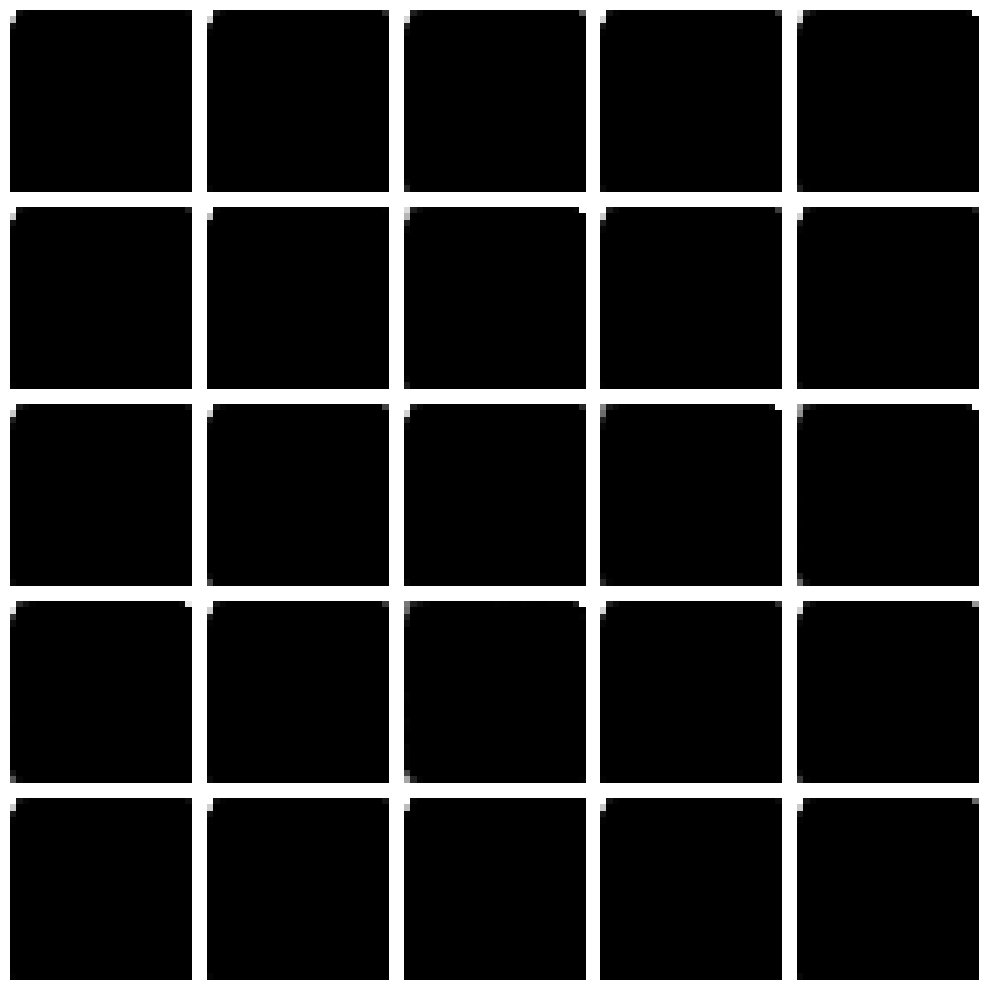


Original vs Reconstructed images:


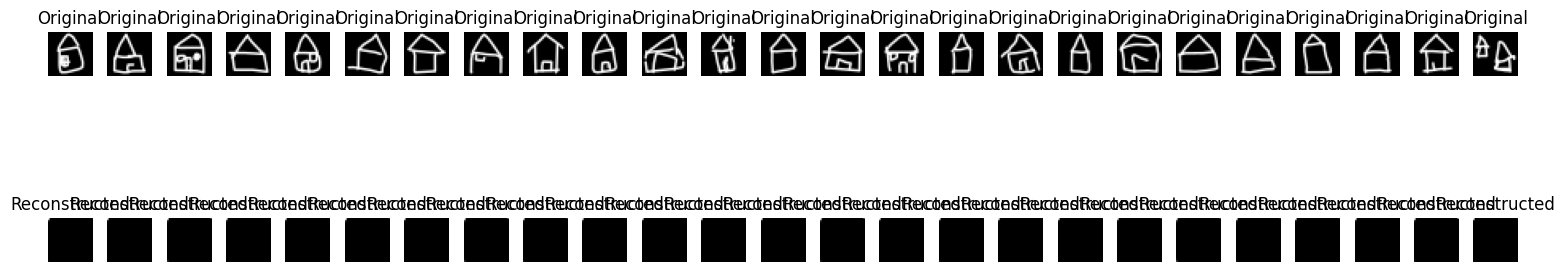


Pixel value ranges for generated images:
Min pixel value: 0.0
Max pixel value: 0.00019628011796157807
Mean pixel value: 1.592021163787649e-07


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Load the saved VAE model
new_vae = keras.models.load_model('trained_vae_model_5epoches.h5', 
                            custom_objects={'VAE': VAE})

def plot_generated_images(model, n=5):
    # Generate random latent vectors
    random_latent_points = tf.random.normal(shape=(n * n, LATENT_DIM))
    
    # Decode them to images
    generated_images = model.decoder(random_latent_points)
    
    # Rescale images 0 - 1
    generated_images = generated_images.numpy()
    
    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_reconstructed_images(model, x_test, n=5):
    # Select test images
    test_images = x_test[:n*n]
    
    # Encode and decode images
    encoded = model.encoder(test_images)
    z = model.sampling(encoded)
    reconstructed_images = model.decoder(z)
    
    # Plot original and reconstructed images
    plt.figure(figsize=(15, 5))
    
    # Plot original images
    for i in range(n * n):
        plt.subplot(2, n*n, i + 1)
        plt.imshow(test_images[i, :, :, 0], cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
    # Plot reconstructed images  
    for i in range(n * n):
        plt.subplot(2, n*n, i + n*n + 1)
        plt.imshow(reconstructed_images[i, :, :, 0], cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Generate new images
print("Generated images:")
plot_generated_images(new_vae)

# Compare original vs reconstructed
print("\nOriginal vs Reconstructed images:")
plot_reconstructed_images(new_vae, x_test)

# Check pixel value ranges
def check_pixel_ranges(images):
    print(f"Min pixel value: {images.numpy().min()}")
    print(f"Max pixel value: {images.numpy().max()}")
    print(f"Mean pixel value: {images.numpy().mean()}")

# Generate some images and check their pixel ranges
random_latent_points = tf.random.normal(shape=(10, LATENT_DIM))
generated_images = new_vae.decoder(random_latent_points)
print("\nPixel value ranges for generated images:")
check_pixel_ranges(generated_images)


# GAN Training

### GAN model

In [31]:
def generate_and_save_images(generator, epoch, batch_idx, noise, save_dir):
    """Generates and saves images from the generator with larger size and higher quality."""
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()
        
        # Rescale images từ [-1, 1] thành [0, 1]
        fake_images = 0.5 * fake_images + 0.5

        # Lưu grid ảnh với kích thước lớn
        fig = plt.figure(figsize=(10, 10))
        for i in range(fake_images.size(0)):
            plt.subplot(4, 4, i + 1)  # Grid 4x4 cho 16 ảnh
            plt.imshow(fake_images[i, 0, :, :], cmap='gray')
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(
            f"{save_dir}/epoch_{epoch}_batch_{batch_idx}.png",
            dpi=300,  # Tăng độ phân giải
            bbox_inches='tight',
            pad_inches=0.1
        )
        plt.close(fig)

Test all GAN


Using device: mps
cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
Epoch [0/1000] Batch [0/12] D_loss: 1.3895 G_loss: 0.7202
Epoch [1/1000] Batch [0/12] D_loss: 1.4108 G_loss: 0.7549
Epoch [2/1000] Batch [0/12] D_loss: 1.3903 G_loss: 0.7449
Epoch [3/1000] Batch [0/12] D_loss: 1.3790 G_loss: 0.8122
Epoch [4/1000] Batch [0/12] D_loss: 1.4021 G_loss: 0.6884
Epoch [5/1000] Batch [0/12] D_loss: 1.3936 G_loss: 0.6677
Epoch [6/1000] Batch [0/12] D_loss: 1.3737 G_loss: 0.7096
Epoch [7/1000] Batch [0/12] D_loss: 1.3519 G_loss: 0.8124
Epoch [8/1000] Batch [0/12] D_loss: 1.3303 G_loss: 0.7042
Epoch [9/1000] Batch [0/12] D_loss: 1.3249 G_loss: 0.8189
Epoch [10/1000] Batch [0/12] D_loss: 1.3290 G_loss: 0.7275
Epoch [11/1000] Batch [0/12] D_loss: 1.3172 G_loss: 0.9306
Epoch [12/1000] Batch [0/12] D_loss: 1.3666 G_loss: 0.7214
Epoch [13/1000] Batch [0/12] D_loss: 1.3377 G_loss: 0.7596
Epoch [14/1000] Batch 

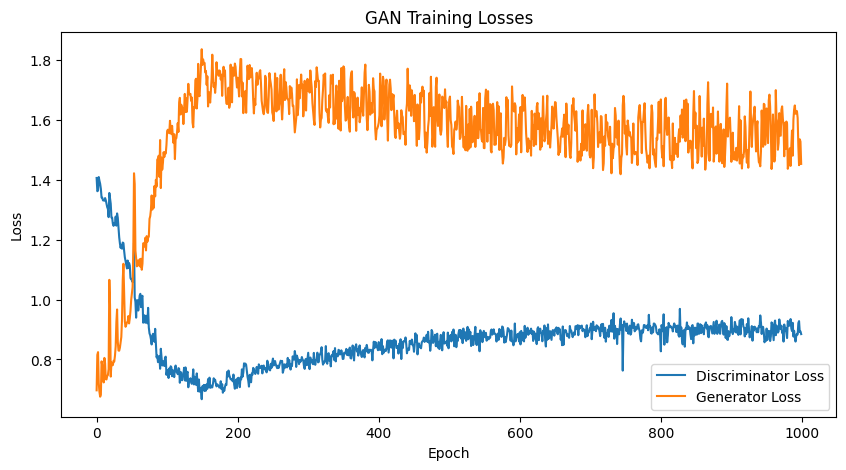

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import urllib.request
from tqdm import tqdm

# Constants
IMAGE_SIZE = 28
CHANNELS = 1 
BATCH_SIZE = 1024  # Tăng batch size cho M1
LATENT_DIM = 128
LATENT_DIM_GAN = 128
EPOCHS = 1000
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']
DATA_DIR = "quickdraw_data"
MAX_ITEMS_PER_CLASS = 3000

# Thiết lập random seed
torch.manual_seed(42)
np.random.seed(42)

# Thiết lập device MPS cho M1
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def download_quickdraw_data(classes, base_url="https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"):
    os.makedirs(DATA_DIR, exist_ok=True)
    for class_name in classes:
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                urllib.request.urlretrieve(base_url + file_name, file_path, 
                    reporthook=lambda b, bsize, tsize: t.update(bsize))
        else:
            print(f"{file_name} already downloaded.")

def load_quickdraw_data(classes, max_items_per_class, data_dir=DATA_DIR):
    all_data = []
    all_labels = []
    for idx, class_name in enumerate(classes):
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(data_dir, file_name)
        try:
            data = np.load(file_path)
            if data.shape[0] > max_items_per_class:
                data = data[:max_items_per_class]
            all_data.append(data)
            all_labels.append(np.full((data.shape[0],), idx))
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            return None, None
    return np.concatenate(all_data), np.concatenate(all_labels)

class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 7 * 7 * 256),
            nn.LeakyReLU(0.2)
        )
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 256, 7, 7)
        img = self.conv_layers(x)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Download và load data
download_quickdraw_data(CLASSES)
x_data, labels = load_quickdraw_data(CLASSES, MAX_ITEMS_PER_CLASS)

if x_data is not None and labels is not None:
    # Chuẩn bị data
    x_data = x_data.reshape(-1, 1, 28, 28).astype('float32') / 255.
    
    # Split train/test
    train_size = int(0.8 * len(x_data))
    x_train = torch.from_numpy(x_data[:train_size]).float()
    y_train = torch.from_numpy(labels[:train_size]).long()
    
    # Tạo DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    # Khởi tạo models
    generator = Generator(LATENT_DIM_GAN).to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    # Training
    start_time = time.time()
    d_losses = []
    g_losses = []

    for epoch in range(EPOCHS):
        epoch_d_losses = []
        epoch_g_losses = []
        
        for batch_idx, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            label_real = torch.ones(batch_size, 1).to(device)
            label_fake = torch.zeros(batch_size, 1).to(device)
            
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, LATENT_DIM_GAN).to(device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            optimizer_G.step()

            epoch_d_losses.append(d_loss.item())
            epoch_g_losses.append(g_loss.item())

            # Thêm phần lưu ảnh sau khi train generator
            if batch_idx % 100 == 0:  # Lưu ảnh mỗi 100 batch
                generate_and_save_images(
                    generator,
                    epoch,
                    batch_idx,
                    noise[:16],  # Chỉ lưu 16 ảnh đầu tiên
                    save_dir
                )
                print(f'Epoch [{epoch}/{EPOCHS}] Batch [{batch_idx}/{len(train_loader)}] '
                    f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')

        # Calculate average losses
        d_losses.append(sum(epoch_d_losses) / len(epoch_d_losses))
        g_losses.append(sum(epoch_g_losses) / len(epoch_g_losses))

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    # Save model
    torch.save(generator.state_dict(), "improved_gan_generator.h5")
    print("Improved GAN generator saved as improved_gan_generator.h5")

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.show()


In [34]:
# Create a generator instance
generator = Generator(latent_dim=LATENT_DIM_GAN)

# Load the saved weights
generator.load_state_dict(torch.load("improved_gan_generator.h5"))

# Put the generator in evaluation mode (important for layers like BatchNorm)
generator.eval()

/var/folders/r4/752pqpt90zxczqv7ghd87g7m0000gp/T/ipykernel_33173/1955986887.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("improve

Generator(
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=12544, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_layers): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

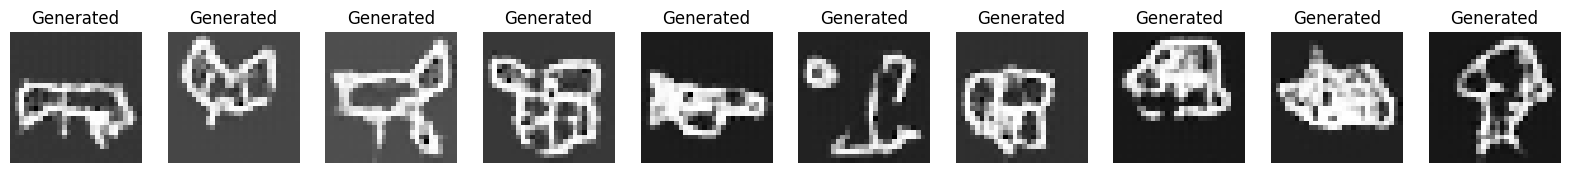

In [35]:
def generate_images(generator, n=10, latent_dim=LATENT_DIM_GAN):
    """Generates new images by sampling from the latent space."""

    with torch.no_grad():  # Disable gradient calculations
        # Sample random noise vectors
        noise = torch.randn(n, latent_dim)

        # Generate images
        generated_images = generator(noise)

    # Rescale images from [-1, 1] to [0, 1] (if you used tanh activation)
    generated_images = 0.5 * generated_images + 0.5

    # Plot the images
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(20, 2))
    for i, image in enumerate(generated_images):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(image.squeeze().detach().numpy(), cmap='gray')  # Convert to NumPy and remove channel dimension
        plt.title("Generated")
        plt.axis("off")
    plt.show()

# Generate 10 images
generate_images(generator, n=10)